### Data Preprocessing

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForMaskedLM
from tqdm.notebook import tqdm
import re
import pickle
import random
import statistics
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
STOPWORDS = set(ENGLISH_STOP_WORDS)
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
TXT_PATH = '/content/The Hunger Games.txt'
with open(TXT_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

In [ ]:
# Basic dimensionality
num_chars = len(raw_text)

# Sentence splitting (regex)
sentences = re.split(r'(?<=[\.\?\!])\s+(?=[A-Z0-9])', raw_text.strip())
sentences = [s for s in sentences if s]
num_sentences = len(sentences)

# Word tokenization (regex)
def word_tokenize(text):
    return re.findall(r"\w+|[^\w\s]", text)

tokens_per_sent = [word_tokenize(s) for s in sentences]
lengths = [len(toks) for toks in tokens_per_sent]
num_tokens = sum(lengths)

# Vocabulary
#   – raw alpha-only tokens
vocab_raw = {tok.lower() for toks in tokens_per_sent for tok in toks
             if re.fullmatch(r"[A-Za-z]+", tok)}
#   – apply minimal cleaning + stopword removal
vocab_raw = {
    tok.lower()
    for toks in tokens_per_sent
    for tok in toks
    if re.fullmatch(r"[A-Za-z]+", tok)
}

vocab_clean = {
    tok.lower()
    for toks in tokens_per_sent
    for tok in toks
    if re.fullmatch(r"[A-Za-z]+", tok)
       and len(tok) >= 3
       and tok.lower() not in STOPWORDS
}

# Outliers
outliers = {
    "too_short (<3 tok)": sum(1 for l in lengths if l < 3),
    "too_long  (>512)":   sum(1 for l in lengths if l > 512)
}

print("=== Data Summary ===")
print(f"Chars           : {num_chars:,}")
print(f"Sentences       : {num_sentences:,}")
print(f"Word-tokens     : {num_tokens:,}")
print("Sent. len (tok) :",
      f"min={min(lengths)}, max={max(lengths)},",
      f"mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths)}")
print(f"Vocab (raw)     : {len(vocab_raw):,}")
print(f"Vocab (clean)   : {len(vocab_clean):,}")
print("Outliers        :", outliers)

# Top 20 cleaned tokens
freq = Counter(
    tok.lower()
    for toks in tokens_per_sent
    for tok in toks
    if re.fullmatch(r"[A-Za-z]+", tok)
       and len(tok) >= 3
       and tok.lower() not in STOPWORDS
)

top20 = freq.most_common(20)
print("\nTop 20 tokens (cleaned):")
for w, c in top20:
    print(f"  {w:<12} {c:>6,}")

=== Data Summary ===
Chars           : 521,930
Sentences       : 8,891
Word-tokens     : 115,592
Sent. len (tok) : min=2, max=78, mean=13.0, median=11
Vocab (raw)     : 7,570
Vocab (clean)   : 7,273
Outliers        : {'too_short (<3 tok)': 225, 'too_long  (>512)': 0}

Top 20 tokens (cleaned):
  peeta           496
  says            420
  say             318
  just            314
  know            272
  dont            266
  district        234
  think           214
  haymitch        208
  like            197
  time            196
  hes             195
  right           182
  theres          171
  ive             167
  make            144
  good            134
  rue             123
  want            121
  head            120


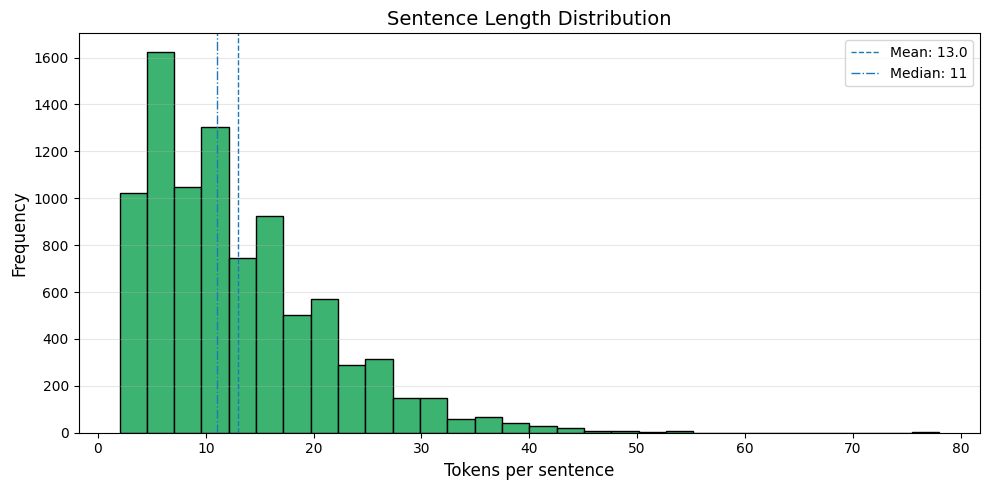

In [ ]:
mean_len = statistics.mean(lengths)
median_len = statistics.median(lengths)

plt.figure(figsize=(10, 5), dpi=100)
plt.hist(lengths, bins=30, color='mediumseagreen', edgecolor='black')
plt.axvline(mean_len, linestyle='--', linewidth=1, label=f"Mean: {mean_len:.1f}")
plt.axvline(median_len, linestyle='-.', linewidth=1, label=f"Median: {median_len}")
plt.title("Sentence Length Distribution", fontsize=14)
plt.xlabel("Tokens per sentence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

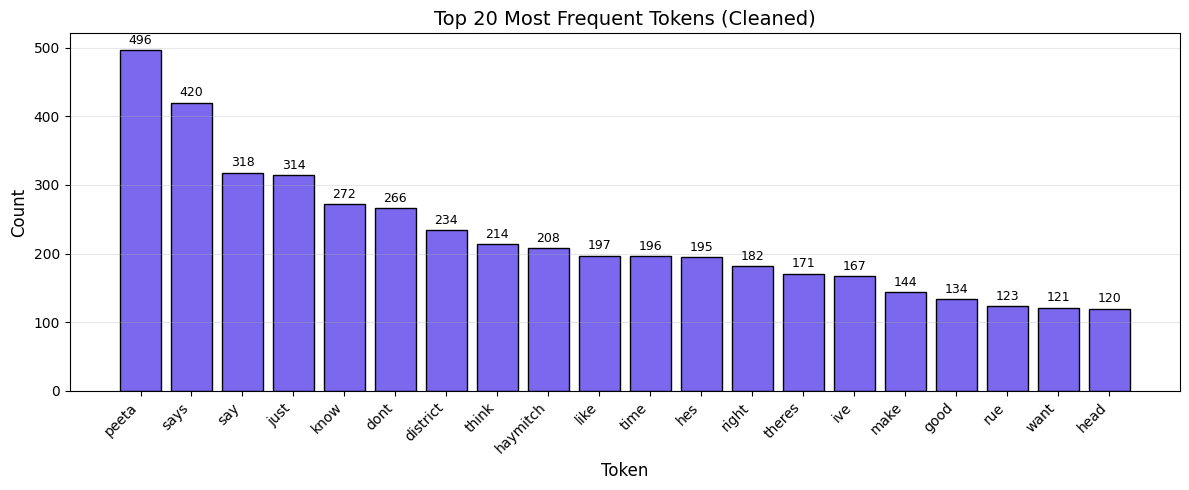

In [ ]:
words, counts = zip(*top20)

plt.figure(figsize=(12, 5))
bars = plt.bar(words, counts, color='mediumslateblue', edgecolor="black")
plt.title("Top 20 Most Frequent Tokens (Cleaned)", fontsize=14)
plt.xlabel("Token", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(counts)*0.01, int(yval),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Inspect BERT max sequence length
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
max_len = tokenizer.model_max_length
print("BERT 'bert-base-uncased' max_length =", max_len)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BERT 'bert-base-uncased' max_length = 512


In [ ]:
# Tokenize all sentences (pad & truncate)
enc = tokenizer(
    sentences,
    max_length=max_len,
    truncation=True,
    padding="max_length",
    return_attention_mask=True
)
input_ids      = enc["input_ids"]        # list of lists
attention_mask = enc["attention_mask"]   # same shape

print(f"Tokenized: {len(input_ids)} examples × {len(input_ids[0])} tokens")

Tokenized: 8891 examples × 512 tokens


In [ ]:
# Bundle & dump to disk
OUTPUT_PATH = "preprocessed_hg.pkl"
preproc = {
    "metadata": {
        "chars"       : num_chars,
        "sentences"   : num_sentences,
        "tokens"      : num_tokens,
        "vocab_raw"   : len(vocab_raw),
        "vocab_clean" : len(vocab_clean),
        "length_stats": {
            "min": min(lengths), "max": max(lengths),
            "mean": statistics.mean(lengths),
            "median": statistics.median(lengths)
        },
        "outliers"    : outliers,
        "top20"       : top20,
        "bert_max_len": max_len
    },
    "sentences"     : sentences,
    "input_ids"     : input_ids,
    "attention_mask": attention_mask
}

with open(OUTPUT_PATH, "wb") as f:
    pickle.dump(preproc, f)

print("Preprocessed data saved to", OUTPUT_PATH)

Preprocessed data saved to preprocessed_hg.pkl


In [ ]:
# Inspect Raw vs. Preprocessed Samples

# load and split raw text
raw_path = 'The Hunger Games.txt'
with open(raw_path, "r", encoding="utf-8") as f:
    raw = f.read()
raw_sentences = re.split(r'(?<=[\.\?\!])\s+(?=[A-Z0-9])', raw.strip())
raw_sentences = [s for s in raw_sentences if s]

# load preprocessed data
prep_path = "preprocessed_hg.pkl"
with open(prep_path, "rb") as f:
    preproc = pickle.load(f)
preproc_sentences = preproc["sentences"]

# display first examples
for i in range(5):
    print(f"\n=== Example {i+1} ===")
    print("Raw:     ", raw_sentences[i])
    print("Preproc: ", preproc_sentences[i])
    print("Token IDs (first 10):", preproc["input_ids"][i][:10], "…")
    print("Attention Mask (first 10):", preproc["attention_mask"][i][:10], "…")


=== Example 1 ===
Raw:      ﻿The Hunger Games


The Hunger Games 1by Suzanne Collins

PART I"THE TRIBUTES"

1.
Preproc:  ﻿The Hunger Games


The Hunger Games 1by Suzanne Collins

PART I"THE TRIBUTES"

1.
Token IDs (first 10): [101, 1996, 9012, 2399, 1996, 9012, 2399, 26314, 2100, 15146] …
Attention Mask (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] …

=== Example 2 ===
Raw:      When I wake up, the other side of the bed is cold.
Preproc:  When I wake up, the other side of the bed is cold.
Token IDs (first 10): [101, 2043, 1045, 5256, 2039, 1010, 1996, 2060, 2217, 1997] …
Attention Mask (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] …

=== Example 3 ===
Raw:      My fingers stretch out, seeking Prims warmth but finding only the rough canvas cover of the mattress.
Preproc:  My fingers stretch out, seeking Prims warmth but finding only the rough canvas cover of the mattress.
Token IDs (first 10): [101, 2026, 3093, 7683, 2041, 1010, 6224, 26927, 5244, 8251] …
Attention Mask (first 10): [1, 1, 1,

### Preparation

In [ ]:
SEED = 42
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}   |   Seed: {SEED}")

🚀 Using device: cuda   |   Seed: 42


In [ ]:
with open("preprocessed_hg.pkl", "rb") as f:
    preproc = pickle.load(f)

input_ids      = torch.tensor(preproc["input_ids"],      dtype=torch.long)
attention_mask = torch.tensor(preproc["attention_mask"], dtype=torch.long)

In [ ]:
PAD_ID, CLS_ID, SEP_ID, MASK_ID = 0, 101, 102, 103

class MaskedLMDataset(Dataset):
    def __init__(self, input_ids, attention_mask, mask_prob=0.2):
        # CPU tensors only
        self.input_ids      = input_ids
        self.attention_mask = attention_mask
        self.mask_prob      = mask_prob

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        orig   = self.input_ids[idx]      # CPU tensor
        mask   = self.attention_mask[idx] # CPU tensor
        inputs = orig.clone()
        labels = torch.full(orig.shape, -100, dtype=torch.long)  # CPU

        # <-- CPU random mask
        rand    = torch.rand(orig.shape)
        to_mask = (
            (rand < self.mask_prob)
            & (orig != PAD_ID)
            & (orig != CLS_ID)
            & (orig != SEP_ID)
        )

        inputs[to_mask] = MASK_ID
        labels[to_mask] = orig[to_mask]

        return {
            "input_ids":      inputs,
            "attention_mask": mask,
            "labels":         labels
        }

dataset = MaskedLMDataset(input_ids, attention_mask)

In [ ]:
total = len(dataset)
train_len = int(0.7 * total)
val_len   = int(0.15 * total)
test_len  = total - train_len - val_len

train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(SEED)
)
print(f"Splits — train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

Splits — train: 6223, val: 1333, test: 1335


In [ ]:
def make_loader(ds, batch_size, shuffle=False):
    return DataLoader(ds, batch_size=batch_size,
                      shuffle=shuffle, num_workers=16,
                      pin_memory=True)

batch_size = 8
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,
                          num_workers=16, pin_memory=True)
val_loader   = make_loader(val_ds,   batch_size)
test_loader  = make_loader(test_ds,  batch_size)

print(f"Splits → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
print(f"Batches→ train: {len(train_loader)}, val: {len(val_loader)}\n")

Splits → train: 6223, val: 1333, test: 1335
Batches→ train: 389, val: 167



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
scaler    = GradScaler()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-16-64628e9b11c3>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()


In [ ]:
scaler = GradScaler()
max_epochs, best_val, patience, bad_epochs = 10, float("inf"), 2, 0
print_every = 50

for epoch in range(1, max_epochs+1):
    model.train()
    train_loss = 0.0
    train_bar  = tqdm(train_loader, desc=f"Train Epoch {epoch}", leave=False)

    for step, batch in enumerate(train_bar, 1):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        with autocast():
            loss = model(**batch).loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_bar.set_postfix(train_loss=f"{loss.item():.4f}")
        if step % print_every == 0:
            print(f"[Epoch {epoch} Step {step}/{len(train_loader)}] loss={loss.item():.4f}")

    avg_train = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    val_bar  = tqdm(val_loader, desc=f"Validate Epoch {epoch}", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            with autocast():
                val_loss += model(**batch).loss.item()
            val_bar.set_postfix(val_loss=f"{val_loss/len(val_bar):.4f}")

    avg_val = val_loss / len(val_loader)
    print(f"\nEpoch {epoch} → train_loss: {avg_train:.4f}, val_loss: {avg_val:.4f}")

    if avg_val < best_val:
        best_val, bad_epochs = avg_val, 0
        model.save_pretrained("best_model")
        print(f"Saved best model (val_loss={best_val:.4f})\n")
    else:
        bad_epochs += 1
        print(f"No improvement (bad_epochs={bad_epochs}/{patience})\n")
        if bad_epochs > patience:
            print(f"Stopping early at epoch {epoch} (best_val={best_val:.4f})")
            break


<ipython-input-17-b2936c9afcdf>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train Epoch 1:   0%|          | 0/389 [00:00<?, ?it/s]

<ipython-input-17-b2936c9afcdf>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1 Step 50/389] loss=2.2832
[Epoch 1 Step 100/389] loss=2.5955
[Epoch 1 Step 150/389] loss=3.0757
[Epoch 1 Step 200/389] loss=3.3002
[Epoch 1 Step 250/389] loss=1.7755
[Epoch 1 Step 300/389] loss=1.8222
[Epoch 1 Step 350/389] loss=2.6772


Validate Epoch 1:   0%|          | 0/167 [00:00<?, ?it/s]

<ipython-input-17-b2936c9afcdf>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1 → train_loss: 2.6853, val_loss: 2.3593
Saved best model (val_loss=2.3593)



Train Epoch 2:   0%|          | 0/389 [00:00<?, ?it/s]

[Epoch 2 Step 50/389] loss=1.7813
[Epoch 2 Step 100/389] loss=2.3264
[Epoch 2 Step 150/389] loss=3.5693
[Epoch 2 Step 200/389] loss=3.0796
[Epoch 2 Step 250/389] loss=2.0861
[Epoch 2 Step 300/389] loss=3.1973
[Epoch 2 Step 350/389] loss=1.7480


Validate Epoch 2:   0%|          | 0/167 [00:00<?, ?it/s]


Epoch 2 → train_loss: 2.3660, val_loss: 2.4184
No improvement (bad_epochs=1/2)



Train Epoch 3:   0%|          | 0/389 [00:00<?, ?it/s]

[Epoch 3 Step 50/389] loss=2.4039
[Epoch 3 Step 100/389] loss=2.3442
[Epoch 3 Step 150/389] loss=1.5907
[Epoch 3 Step 200/389] loss=2.3311
[Epoch 3 Step 250/389] loss=2.0357
[Epoch 3 Step 300/389] loss=1.9493
[Epoch 3 Step 350/389] loss=2.3194


Validate Epoch 3:   0%|          | 0/167 [00:00<?, ?it/s]


Epoch 3 → train_loss: 2.1621, val_loss: 2.2864
Saved best model (val_loss=2.2864)



Train Epoch 4:   0%|          | 0/389 [00:00<?, ?it/s]

[Epoch 4 Step 50/389] loss=2.3632
[Epoch 4 Step 100/389] loss=1.5179
[Epoch 4 Step 150/389] loss=1.1602
[Epoch 4 Step 200/389] loss=1.5233
[Epoch 4 Step 250/389] loss=1.7198
[Epoch 4 Step 300/389] loss=1.4140
[Epoch 4 Step 350/389] loss=2.5146


Validate Epoch 4:   0%|          | 0/167 [00:00<?, ?it/s]


Epoch 4 → train_loss: 2.1006, val_loss: 2.4402
No improvement (bad_epochs=1/2)



Train Epoch 5:   0%|          | 0/389 [00:00<?, ?it/s]

[Epoch 5 Step 50/389] loss=1.8553
[Epoch 5 Step 100/389] loss=1.9080
[Epoch 5 Step 150/389] loss=1.3258
[Epoch 5 Step 200/389] loss=2.7638
[Epoch 5 Step 250/389] loss=2.4407
[Epoch 5 Step 300/389] loss=2.6750
[Epoch 5 Step 350/389] loss=1.4117


Validate Epoch 5:   0%|          | 0/167 [00:00<?, ?it/s]


Epoch 5 → train_loss: 2.0026, val_loss: 2.4900
No improvement (bad_epochs=2/2)



Train Epoch 6:   0%|          | 0/389 [00:00<?, ?it/s]

[Epoch 6 Step 50/389] loss=1.3506
[Epoch 6 Step 100/389] loss=1.4197
[Epoch 6 Step 150/389] loss=1.9308
[Epoch 6 Step 200/389] loss=1.9338
[Epoch 6 Step 250/389] loss=2.1289
[Epoch 6 Step 300/389] loss=2.9055
[Epoch 6 Step 350/389] loss=1.4229


Validate Epoch 6:   0%|          | 0/167 [00:00<?, ?it/s]


Epoch 6 → train_loss: 1.8907, val_loss: 2.3812
No improvement (bad_epochs=3/2)

Stopping early at epoch 6 (best_val=2.2864)


In [ ]:
output_dir = "hg_bert_mlm_finetuned"
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model & tokenizer saved to {output_dir}")

Model & tokenizer saved to hg_bert_mlm_finetuned


In [ ]:
!zip -r hg_bert_mlm_finetuned.zip hg_bert_mlm_finetuned

from google.colab import files
files.download("hg_bert_mlm_finetuned.zip")

  adding: hg_bert_mlm_finetuned/ (stored 0%)
  adding: hg_bert_mlm_finetuned/vocab.txt (deflated 53%)
  adding: hg_bert_mlm_finetuned/special_tokens_map.json (deflated 42%)
  adding: hg_bert_mlm_finetuned/model.safetensors (deflated 7%)
  adding: hg_bert_mlm_finetuned/tokenizer_config.json (deflated 75%)
  adding: hg_bert_mlm_finetuned/config.json (deflated 47%)
  adding: hg_bert_mlm_finetuned/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. Make a folder to collect the files
!mkdir -p artifacts
# 2. Copy in everything you want to save:
!cp preprocessed_hg.pkl artifacts/
!cp -r hg_bert_mlm_finetuned artifacts/
!cp -r best_model artifacts/

# 3. Zip the folder
!zip -r artifacts.zip artifacts

# 4. Download it
files.download("artifacts.zip")

  adding: artifacts/ (stored 0%)
  adding: artifacts/hg_bert_mlm_finetuned/ (stored 0%)
  adding: artifacts/hg_bert_mlm_finetuned/vocab.txt (deflated 53%)
  adding: artifacts/hg_bert_mlm_finetuned/special_tokens_map.json (deflated 42%)
  adding: artifacts/hg_bert_mlm_finetuned/model.safetensors (deflated 7%)
  adding: artifacts/hg_bert_mlm_finetuned/tokenizer_config.json (deflated 75%)
  adding: artifacts/hg_bert_mlm_finetuned/config.json (deflated 47%)
  adding: artifacts/hg_bert_mlm_finetuned/tokenizer.json (deflated 71%)
  adding: artifacts/best_model/ (stored 0%)
  adding: artifacts/best_model/model.safetensors (deflated 7%)
  adding: artifacts/best_model/config.json (deflated 47%)
  adding: artifacts/preprocessed_hg.pkl (deflated 97%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Masked Language Head

In [4]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizerFast

# 1) Load base BERT (no MLM head)
bert = BertModel.from_pretrained("bert-base-uncased")
config     = bert.config
H, V       = config.hidden_size, config.vocab_size  # 768, ~30522

# 2) Define the enhanced masked‐language head
class EnhancedMLMHead(nn.Module):
    def __init__(self, bert_model, hidden_size, vocab_size, dropout=0.1):
        super().__init__()
        # tie decoder weights to BERT’s input embeddings
        self.word_embeddings = bert_model.embeddings.word_embeddings

        # hidden block #1
        self.dense1 = nn.Linear(hidden_size, hidden_size)
        self.act1   = nn.GELU()
        self.ln1    = nn.LayerNorm(hidden_size)
        self.drop1  = nn.Dropout(dropout)

        # hidden block #2
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.act2   = nn.GELU()
        self.ln2    = nn.LayerNorm(hidden_size)
        self.drop2  = nn.Dropout(dropout)

        # final decoder (no bias) + separate bias parameter
        self.decoder = nn.Linear(hidden_size, vocab_size, bias=False)
        self.decoder.weight = self.word_embeddings.weight
        self.bias    = nn.Parameter(torch.zeros(vocab_size))

        # Xavier init for new layers
        for module in [self.dense1, self.dense2, self.decoder]:
            nn.init.xavier_uniform_(module.weight)

    def forward(self, embeddings, masked_positions=None):
        """
        embeddings: (B, L, H)
        masked_positions (optional): BoolTensor (B, L)
        returns:
          if masked_positions is None → logits (B, L, V)
          else → logits only at masked positions: (sum(masked), V)
        """
        x = self.drop1(self.ln1(self.act1(self.dense1(embeddings))))
        x = self.drop2(self.ln2(self.act2(self.dense2(x))))
        logits = self.decoder(x) + self.bias  # (B, L, V)

        if masked_positions is not None:
            # flatten & select only masked indices for loss speedup
            mask_flat = masked_positions.view(-1)
            logits    = logits.view(-1, logits.size(-1))[mask_flat]
        return logits

# instantiate the head
mlm_head = EnhancedMLMHead(bert, H, V)

# 3) Sanity‐check on a random batch
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
B, L = 2, 12
# random input IDs in [0, V)
rand_ids = torch.randint(0, V, (B, L))
attn_mask= torch.ones_like(rand_ids)
# random mask flags
mask_flags = (torch.rand(B, L) < 0.2)

with torch.no_grad():
    # get BERT embeddings
    bert_out    = bert(input_ids=rand_ids, attention_mask=attn_mask)
    embeddings  = bert_out.last_hidden_state       # (B, L, H)
    # full logits
    full_logits = mlm_head(embeddings)             # (B, L, V)
    # masked-only logits
    sel_logits  = mlm_head(embeddings, mask_flags) # (~0.2*B*L, V)

print("Embeddings shape:        ", embeddings.shape)   # torch.Size([2,12,768])
print("Full logits shape:       ", full_logits.shape)  # torch.Size([2,12,30522])
print("Masked-only logits shape:", sel_logits.shape)   # torch.Size([~5,30522])

Embeddings shape:         torch.Size([2, 12, 768])
Full logits shape:        torch.Size([2, 12, 30522])
Masked-only logits shape: torch.Size([6, 30522])


### Metrics and Training

In [12]:
import os, math, random, pickle
from itertools import chain

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizerFast, BertForMaskedLM, get_linear_schedule_with_warmup
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

# ─── 0) Repro & Device ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}, seed={SEED}")

# ─── 1) Load Preprocessed Data & Raw Sentences ──────────────────────────────────
with open("preprocessed_hg.pkl","rb") as f:
    preproc = pickle.load(f)
sentences          = preproc["sentences"]
all_input_ids      = torch.tensor(preproc["input_ids"])
all_attention_mask = torch.tensor(preproc["attention_mask"])
N = len(all_input_ids)

# ─── 2) MaskedLM Dataset & 70/15/15 Split ────────────────────────────────────────
class MaskedLMDataset(Dataset):
    def __init__(self, ids, mask, p=0.2):
        self.ids  = ids
        self.mask = mask
        self.p    = p
    def __len__(self): return len(self.ids)
    def __getitem__(self, i):
        x   = self.ids[i].clone()
        m   = self.mask[i]
        lbl = torch.full_like(x, -100)
        rand= torch.rand(x.shape, device=x.device)
        to_mask = (rand<self.p)&(x!=0)&(x!=101)&(x!=102)
        lbl[to_mask] = x[to_mask]
        x[to_mask]   = 103
        return {"input_ids": x, "attention_mask": m, "labels": lbl}

n_tr = int(0.7*N)
n_va = int(0.15*N)
n_te = N - n_tr - n_va

full_ds = MaskedLMDataset(all_input_ids, all_attention_mask)
train_ds, val_ds, test_ds = random_split(full_ds, [n_tr,n_va,n_te],
    generator=torch.Generator().manual_seed(SEED))

# keep raw sentence indices for PPL
_, val_idxs, test_idxs = random_split(list(range(N)), [n_tr,n_va,n_te],
    generator=torch.Generator().manual_seed(SEED))
val_texts  = [sentences[i] for i in val_idxs]
test_texts = [sentences[i] for i in test_idxs]

def make_loader(ds, bs, shuffle=False):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle,
                      num_workers=4, pin_memory=True)

BATCH = 16
train_loader      = make_loader(train_ds, BATCH, shuffle=True)
val_loader_masked = make_loader(val_ds,   BATCH)
test_loader_masked= make_loader(test_ds,  BATCH)

# ─── 3) Pseudo-perplexity (appendix) ────────────────────────────────────────────
def compute_mlm_perplexity(model, tokenizer, texts, device="cuda", batch_size=32):
    model.eval()
    ce = nn.CrossEntropyLoss(reduction="none", ignore_index=-100)
    variants_per_text = []
    for txt in tqdm(texts, desc="PPL ▶ texts", leave=False):
        toks = tokenizer.tokenize(txt)
        vs = []
        for pos in range(len(toks)):
            tmp = toks.copy()
            orig_id = tokenizer.convert_tokens_to_ids(tmp[pos])
            tmp[pos] = tokenizer.mask_token
            enc = tokenizer(tokenizer.convert_tokens_to_string(tmp),
                            return_tensors="pt",
                            padding="max_length",
                            truncation=True,
                            max_length=tokenizer.model_max_length)
            lbl = torch.full_like(enc.input_ids, -100)
            lbl[0,pos+1] = orig_id
            enc["labels"] = lbl
            vs.append({k:v.to(device) for k,v in enc.items()})
        variants_per_text.append(vs)

    flat, nlls = list(chain(*variants_per_text)), []
    for i in tqdm(range(0, len(flat), batch_size),
                  desc="PPL ▶ variants", leave=False):
        batch = {k: torch.cat([x[k] for x in flat[i:i+batch_size]],0)
                 for k in ("input_ids","attention_mask","labels")}
        with torch.no_grad():
            out = model(**batch)
        logits = out.logits.view(-1, out.logits.size(-1))
        labs   = batch["labels"].view(-1)
        loss   = ce(logits, labs).view(batch["labels"].size())
        nlls.extend(loss.sum(dim=1).cpu().tolist())

    ppls, idx = [], 0
    for vs in variants_per_text:
        L = len(vs)
        total_nll = sum(nlls[idx:idx+L])
        ppls.append(math.exp(total_nll / L))
        idx += L
    return ppls

# ─── 4) Pre-fine-tune PPL ───────────────────────────────────────────────────────
print("\n▶ Pre-fine-tune PPL:")
base_model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)
base_tok   = BertTokenizerFast.from_pretrained("bert-base-uncased")
pv = np.mean(compute_mlm_perplexity(base_model, base_tok, val_texts,  device, 32))
pt = np.mean(compute_mlm_perplexity(base_model, base_tok, test_texts, device, 32))
print(f"   val PPL = {pv:.2f},   test PPL = {pt:.2f}\n")

# ─── 5) Fine-tuning + Early Stopping ────────────────────────────────────────────
model     = base_model
tokenizer = base_tok
optim     = AdamW(model.parameters(), lr=1e-4)
steps     = len(train_loader)*10
warmup    = int(0.1*steps)
sched     = get_linear_schedule_with_warmup(optim,warmup,steps)
scaler    = GradScaler()

train_nlls, val_nlls = [], []
train_ppls, val_ppls = [], []
best_val_nll = float("inf")
patience     = 2
bad = 0

print("▶ Starting fine-tuning:")
for ep in trange(1,11, desc="Epochs"):
    # — train —
    model.train()
    cum_nll, cum_toks = 0.0, 0
    bar = tqdm(train_loader, desc=f"Train Ep{ep}", leave=False)
    for batch in bar:
        optim.zero_grad()
        batch = {k:v.to(device) for k,v in batch.items()}
        with autocast():
            loss = model(**batch).loss
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        sched.step()

        nt = (batch["labels"]!=-100).sum().item()
        cum_nll  += loss.item()*nt
        cum_toks += nt
        bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_nll = cum_nll/cum_toks
    train_nlls.append(avg_nll)
    train_ppls.append(math.exp(avg_nll))

    # — validate —
    vp = compute_mlm_perplexity(model,tokenizer,val_texts,device,32)
    val_nll = math.log(np.mean(vp));  val_ppl = np.mean(vp)
    val_nlls.append(val_nll);        val_ppls.append(val_ppl)

    print(f"\nEp{ep}: train_PPL={train_ppls[-1]:.2f}, val_PPL={val_ppls[-1]:.2f}")
    if val_nll < best_val_nll:
        best_val_nll, bad = val_nll, 0
        model.save_pretrained("best_model4")
        tokenizer.save_pretrained("best_model4")
        print("   🎉 New best model saved.")
    else:
        bad += 1
        print(f"   ⚠️  No improvement ({bad}/{patience})")
        if bad>patience:
            print(f"⏹ Early stopping @ epoch {ep}")
            break

# ─── 6) Final Test PPL ───────────────────────────────────────────────────────────
tp = compute_mlm_perplexity(model,tokenizer,test_texts,device,32)
print(f"\n▶ Final test PPL = {np.mean(tp):.2f}")

Using device: cuda, seed=42

▶ Pre-fine-tune PPL:


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PPL ▶ texts:   0%|          | 0/1333 [00:00<?, ?it/s]

PPL ▶ variants:   0%|          | 0/571 [00:00<?, ?it/s]

PPL ▶ texts:   0%|          | 0/1335 [00:00<?, ?it/s]

PPL ▶ variants:   0%|          | 0/600 [00:00<?, ?it/s]

   val PPL = 85.45,   test PPL = 77.53

▶ Starting fine-tuning:


<ipython-input-12-ae06217c97ce>:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train Ep1:   0%|          | 0/389 [00:01<?, ?it/s]

<ipython-input-12-ae06217c97ce>:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


PPL ▶ texts:   0%|          | 0/1333 [00:00<?, ?it/s]

PPL ▶ variants:   0%|          | 0/571 [00:00<?, ?it/s]


Ep1: train_PPL=15.16, val_PPL=18.54
   🎉 New best model saved.


Train Ep2:   0%|          | 0/389 [00:00<?, ?it/s]

PPL ▶ texts:   0%|          | 0/1333 [00:00<?, ?it/s]

PPL ▶ variants:   0%|          | 0/571 [00:00<?, ?it/s]


Ep2: train_PPL=12.37, val_PPL=18.58
   ⚠️  No improvement (1/2)


Train Ep3:   0%|          | 0/389 [00:00<?, ?it/s]

PPL ▶ texts:   0%|          | 0/1333 [00:00<?, ?it/s]

PPL ▶ variants:   0%|          | 0/571 [00:00<?, ?it/s]


Ep3: train_PPL=10.81, val_PPL=19.42
   ⚠️  No improvement (2/2)


Train Ep4:   0%|          | 0/389 [00:00<?, ?it/s]

PPL ▶ texts:   0%|          | 0/1333 [00:00<?, ?it/s]

PPL ▶ variants:   0%|          | 0/571 [00:00<?, ?it/s]


Ep4: train_PPL=8.91, val_PPL=19.33
   ⚠️  No improvement (3/2)
⏹ Early stopping @ epoch 4


PPL ▶ texts:   0%|          | 0/1335 [00:00<?, ?it/s]

PPL ▶ variants:   0%|          | 0/600 [00:00<?, ?it/s]


▶ Final test PPL = 15.92


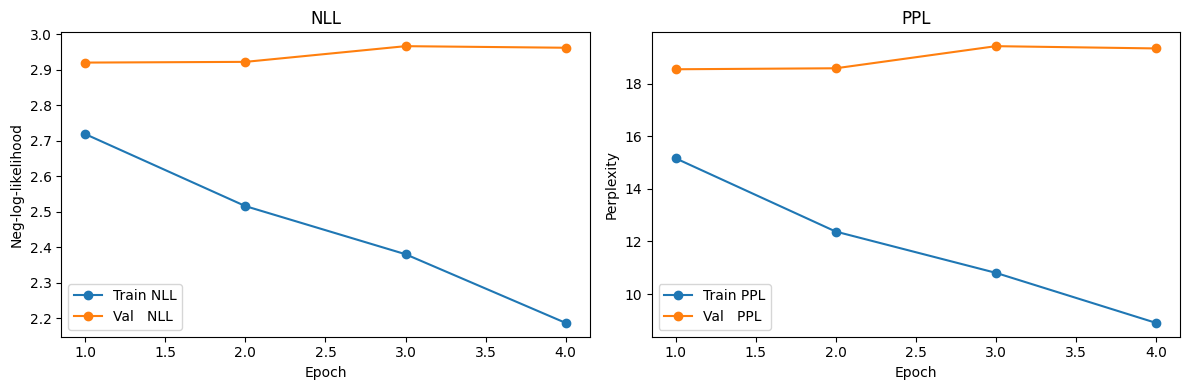

In [13]:
# ─── 7) Plot NLL & PPL Curves ────────────────────────────────────────────────────
epochs = list(range(1, len(train_nlls)+1))
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_nlls, marker='o', label="Train NLL")
plt.plot(epochs, val_nlls,   marker='o', label="Val   NLL")
plt.xlabel("Epoch"); plt.ylabel("Neg-log-likelihood")
plt.title("NLL"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_ppls, marker='o', label="Train PPL")
plt.plot(epochs, val_ppls,   marker='o', label="Val   PPL")
plt.xlabel("Epoch"); plt.ylabel("Perplexity")
plt.title("PPL"); plt.legend()

plt.tight_layout(); plt.show()

In [24]:
# ─── 8) Human-crafted masks with best_model4 ─────────────────────────────────────
best_m = BertForMaskedLM.from_pretrained("best_model4").to(device)
best_t = BertTokenizerFast.from_pretrained("best_model4")

examples = [
    "I would have appreciated some [MASK] given our [MASK].",
    "She [MASK] to the store before sunrise.",
    "The researcher published his findings in the [MASK]."
]
for s in examples:
    enc      = best_t(s, return_tensors="pt").to(device)
    mask_pos = (enc.input_ids == best_t.mask_token_id).nonzero(as_tuple=False)
    with torch.no_grad():
        logits = best_m(**enc).logits

    print(f"\nContext: {s}")
    for (_, p) in mask_pos:
        probs = torch.softmax(logits[0, p], dim=-1)
        top5  = torch.topk(probs, 5)
        toks  = best_t.convert_ids_to_tokens(top5.indices.tolist())
        for w, prob in zip(toks, top5.values.tolist()):
            print(f"   {w:12} ({prob:.4f})")


Context: I would have appreciated some [MASK] given our [MASK].
   ,            (0.1669)
   space        (0.0354)
   privacy      (0.0294)
   time         (0.0275)
   help         (0.0233)
   situation    (0.0800)
   history      (0.0653)
   audience     (0.0257)
   circumstances (0.0221)
   friendship   (0.0208)

Context: She [MASK] to the store before sunrise.
   got          (0.2071)
   returned     (0.1924)
   went         (0.1119)
   ran          (0.0720)
   goes         (0.0375)

Context: The researcher published his findings in the [MASK].
   paper        (0.1438)
   press        (0.1226)
   journal      (0.0289)
   newspaper    (0.0260)
   media        (0.0219)


### Masked Language Generation

In [23]:
def generate_masked_continuation(
    prompt:str,
    n_iter:int=10,
    top_k:int=20,
    temperature:float=1.0,
    max_retries:int=5
) -> str:
    mask_tok = tokenizer.mask_token
    for _ in range(n_iter):
        # ensure exactly one trailing [MASK]
        prompt = prompt.rstrip()
        if not prompt.endswith(mask_tok):
            prompt = prompt + " " + mask_tok

        enc       = tokenizer(prompt, return_tensors="pt").to(device)
        mask_pos  = (enc.input_ids[0]==tokenizer.mask_token_id).nonzero(as_tuple=True)[0][0]

        with torch.no_grad():
            logits  = model(**enc).logits[0, mask_pos]  # (vocab,)
        # temperature and top_k
        scaled    = logits / temperature
        vals, idx = torch.topk(scaled, top_k)
        probs     = F.softmax(vals, dim=-1)

        # sample a “real” token (not pure punctuation)
        for _try in range(max_retries):
            choice = idx[torch.multinomial(probs,1)].item()
            tok    = tokenizer.convert_ids_to_tokens(choice)
            if any(c.isalnum() for c in tok.replace("##","")):
                break

        # replace last [MASK] and re-append one
        head, _ = prompt.rsplit(mask_tok, 1)
        prompt  = head.strip() + " " + tok + " " + mask_tok

    # strip off the final mask
    return prompt.replace(mask_tok,"").strip()

# ─── Example ───────────────────────────────────────────────────────────────────
seed_prompt = (
    "Luke Skywalker ignited his blue lightsaber as he stepped onto the Death Star deck, "
    "the distant hum of TIE fighters echoing through the corridor [MASK]"
)

out = generate_masked_continuation(
    seed_prompt,
    n_iter=10,
    top_k=20,
    temperature=0.8
)
print("\n▶ Generated continuation:\n", out)


▶ Generated continuation:
 Luke Skywalker ignited his blue lightsaber as he stepped onto the Death Star deck, the distant hum of TIE fighters echoing through the corridor . . . . . . . . . .


In [18]:
!zip -r all_artifacts.zip best_model4/ preprocessed_hg.pkl

from google.colab import files
files.download("all_artifacts.zip")

updating: best_model4/ (stored 0%)
updating: best_model4/vocab.txt (deflated 53%)
updating: best_model4/special_tokens_map.json (deflated 42%)
updating: best_model4/model.safetensors (deflated 7%)
updating: best_model4/tokenizer_config.json (deflated 75%)
updating: best_model4/config.json (deflated 47%)
updating: best_model4/tokenizer.json (deflated 71%)
updating: preprocessed_hg.pkl (deflated 97%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>